In [1]:

import pandas as pd
import re
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')


In [2]:
#pip install statsmodels


In [3]:
#pip install lxml

### Data Cleaning

#### Vehicle registration


In [4]:
url_2023 = "https://afdc.energy.gov/vehicle-registration?year=2023"
tables = pd.read_html(url_2023)
df_2023 = tables[0] 

url_2022 = "https://afdc.energy.gov/vehicle-registration?year=2022"
tables_2022 = pd.read_html(url_2022)
df_2022 = tables_2022[0]

url_2021 = "https://afdc.energy.gov/vehicle-registration?year=2021"
tables_2021 = pd.read_html(url_2021)
df_2021 = tables_2021[0]

url_2020 = "https://afdc.energy.gov/vehicle-registration?year=2020"
tables_2020 = pd.read_html(url_2020)
df_2020 = tables_2020[0] 

In [5]:
registration_2023 = df_2023.iloc[:, :2]
registration_2022 = df_2022.iloc[:, :2]
registration_2021 = df_2021.iloc[:, :2]
registration_2020 = df_2020.iloc[:, :2]

#combine all years into a single dataframe
all_registrations = pd.concat([registration_2023, registration_2022, registration_2021, registration_2020], axis=0)
all_registrations.columns = ['State', 'Registrations']
all_registrations['Year'] = [2023]*len(registration_2023) + [2022]*len(registration_2022) + [2021]*len(registration_2021) + [2020]*len(registration_2020)   
all_registrations.head()

,State,Registrations,Year
0,Alabama,13000,2023
1,Alaska,2700,2023
2,Arizona,89800,2023
3,Arkansas,7100,2023
4,California,1256600,2023


#### Charging ports

In [7]:
# Read the CSV and keep only State and Ports columns (trim header/footers as needed)
ports_2020 = pd.read_csv('DSC190/Datasets/2020_ports.csv', header=None, dtype=str)
ports_2021 = pd.read_csv('DSC190/Datasets/2021_ports.csv', header=None, dtype=str)
ports_2022 = pd.read_csv('DSC190/Datasets/2022_ports.csv', header=None, dtype=str)
ports_2023 = pd.read_csv('DSC190/Datasets/2023_ports.csv', header=None, dtype=str)

# The useful data rows start after the first 3 rows in this file; slice accordingly (adjust if necessary)
ports_2020 = ports_2020.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})
ports_2021 = ports_2021.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})
ports_2022 = ports_2022.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})
ports_2023 = ports_2023.iloc[3:107, [0, 4]].rename(columns={0: 'State', 4: 'Ports'})

# Drop rows where State is missing/blank
ports_2020['State'] = ports_2020['State'].astype(str).str.strip()
ports_2020 = ports_2020[ports_2020['State'].notna() & (ports_2020['State'] != '')]

ports_2021['State'] = ports_2021['State'].astype(str).str.strip()
ports_2021 = ports_2021[ports_2021['State'].notna() & (ports_2021['State'] != '')]

ports_2022['State'] = ports_2022['State'].astype(str).str.strip()
ports_2022 = ports_2022[ports_2022['State'].notna() & (ports_2022['State'] != '')]

ports_2023['State'] = ports_2023['State'].astype(str).str.strip()
ports_2023 = ports_2023[ports_2023['State'].notna() & (ports_2023['State'] != '')]

# Extract the second number from the Ports column

def extract_second_number(s):
    if pd.isna(s):
        return pd.NA
    s = str(s)
    # split on '|' or '/' or ','
    parts = [p.strip() for p in re.split(r"\||/", s) if p.strip()!='']
    if len(parts) >= 2:
        num = parts[1].replace(',','')
        try:
            return int(num)
        except Exception:
            return pd.NA
    return pd.NA

ports_2020['Charging_Outlets'] = ports_2020['Ports'].apply(extract_second_number)

# Now keep only State and Charging_Outlets and aggregate by state (sum in case of continuation rows)
ports_2020_simple = (
    ports_2020.dropna(subset=['State'])
    .groupby('State', as_index=False)['Charging_Outlets']
    .sum(min_count=1)
)

ports_2021['Charging_Outlets'] = ports_2021['Ports'].apply(extract_second_number)

# Now keep only State and Charging_Outlets and aggregate by state (sum in case of continuation rows)
ports_2021_simple = (
    ports_2021.dropna(subset=['State'])
    .groupby('State', as_index=False)['Charging_Outlets']
    .sum(min_count=1)
)

ports_2022['Charging_Outlets'] = ports_2022['Ports'].apply(extract_second_number)

# Now keep only State and Charging_Outlets and aggregate by state (sum in case of continuation rows)
ports_2022_simple = (
    ports_2022.dropna(subset=['State'])
    .groupby('State', as_index=False)['Charging_Outlets']
    .sum(min_count=1)
)

ports_2023['Charging_Outlets'] = ports_2023['Ports'].apply(extract_second_number)

# Now keep only State and Charging_Outlets and aggregate by state (sum in case of continuation rows)
ports_2023_simple = (
    ports_2023.dropna(subset=['State'])
    .groupby('State', as_index=False)['Charging_Outlets']
    .sum(min_count=1)
)

In [8]:
all_ports = pd.concat([ports_2020_simple.assign(Year=2020),
                    ports_2021_simple.assign(Year=2021),
                    ports_2022_simple.assign(Year=2022),
                    ports_2023_simple.assign(Year=2023)],
                    axis=0)
all_ports.head()

,State,Charging_Outlets,Year
0,Alabama,598,2020
1,Alaska,68,2020
2,Arizona,1788,2020
3,Arkansas,350,2020
4,California,34924,2020


#### Population

In [10]:
population_df = pd.read_csv('DSC190/Datasets/population_estimate.csv', dtype={'Year': int, 'Population': int})
population_df = population_df.iloc[14:, 4:10].reset_index(drop=True)
population_df = population_df.drop([51])
population_df = population_df.rename(columns={"NAME" : 'State', "ESTIMATESBASE2020": 'Base2020', "POPESTIMATE2020": '2020', "POPESTIMATE2021": '2021', "POPESTIMATE2022": '2022', "POPESTIMATE2023": '2023' })
population_df.head()

,State,Base2020,2020,2021,2022,2023
0,Alabama,5025369,5033094,5049196,5076181,5117673
1,Alaska,733395,733017,734420,734442,736510
2,Arizona,7158110,7187135,7274078,7377566,7473027
3,Arkansas,3011553,3014546,3026870,3047704,3069463
4,California,39555674,39521958,39142565,39142414,39198693


### Data Analysis
#### Merge data

In [11]:
# Per-capita analysis: merge data, compute metrics, run correlations and regressions

# --- Prepare population dataframe (wide -> long) ---
# Expect population_df to have columns like 'State', '2020', '2021', '2022', '2023'
pop = population_df.copy()
# If column names are numeric strings, ensure they exist; otherwise try alternatives
year_cols = [c for c in pop.columns if str(c) in ['2020','2021','2022','2023']]
if not year_cols:
    # try exact keys
    for k in ['2020','2021','2022','2023']:
        if k in pop.columns:
            year_cols.append(k)

if 'State' not in pop.columns and 'NAME' in pop.columns:
    pop = pop.rename(columns={'NAME':'State'})

# Melt to long format
pop_long = pop.melt(id_vars=['State'], value_vars=[c for c in ['2020','2021','2022','2023'] if c in pop.columns],
                    var_name='Year', value_name='Population')
pop_long['Year'] = pop_long['Year'].astype(int)
pop_long['Population'] = pd.to_numeric(pop_long['Population'], errors='coerce')

# --- Clean registrations ---
regs = all_registrations.copy()
# Ensure Year column numeric
if regs['Year'].dtype == object:
    regs['Year'] = regs['Year'].astype(str).str.extract(r"(\d{4})").astype(float).astype('Int64')
else:
    regs['Year'] = regs['Year'].astype(int)

# Clean Registrations numeric
regs['Registrations'] = regs['Registrations'].astype(str).str.replace(r'[^0-9]', '', regex=True)
regs['Registrations'] = pd.to_numeric(regs['Registrations'], errors='coerce')

# --- Clean ports ---
ports = all_ports.copy()
if 'Charging_Outlets' in ports.columns:
    ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')
else:
    # fallback: if Ports exists
    if 'Ports' in ports.columns:
        ports['Charging_Outlets'] = ports['Ports'].astype(str).str.replace(r'[^0-9]', '', regex=True)
        ports['Charging_Outlets'] = pd.to_numeric(ports['Charging_Outlets'], errors='coerce')

# Ensure Year numeric
ports['Year'] = ports['Year'].astype(int)

# Standardize State names by stripping whitespace
for df in (ports, regs, pop_long):
    df['State'] = df['State'].astype(str).str.strip()

# --- Merge ---
merged = (
    ports.merge(regs[['State','Year','Registrations']], on=['State','Year'], how='inner')
        .merge(pop_long[['State','Year','Population']], on=['State','Year'], how='inner')
)

# Drop rows with missing key values
merged = merged.dropna(subset=['Charging_Outlets','Registrations','Population']).copy()

# Derived metrics
merged['Outlets_per_100k'] = merged['Charging_Outlets'] / merged['Population'] * 100000
merged['EVs_per_1000'] = merged['Registrations'] / merged['Population'] * 1000
merged['log_Outlets_pc'] = np.log1p(merged['Charging_Outlets'] / merged['Population'])
merged['log_EVs_pc'] = np.log1p(merged['Registrations'] / merged['Population'])

print(merged[['State','Year','Charging_Outlets','Registrations','Population']].head())

        State  Year  Charging_Outlets  Registrations  Population
0     Alabama  2020               598           2900     5033094
1      Alaska  2020                68            900      733017
2     Arizona  2020              1788          28800     7187135
3    Arkansas  2020               350           1300     3014546
4  California  2020             34924         425300    39521958


#### Correlation & OLS

In [12]:
# --- Descriptive & correlations ---
print('\nDescriptive stats:')
print(merged[['Outlets_per_100k','EVs_per_1000']].describe())
pearson = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='pearson')
spearman = merged['Outlets_per_100k'].corr(merged['EVs_per_1000'], method='spearman')
print(f"Pearson correlation (Outlets_per_100k vs EVs_per_1000): {pearson:.3f}")
print(f"Spearman correlation: {spearman:.3f}")

# --- Cross-sectional OLS on latest year ---
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
print(f"\nRunning cross-sectional OLS for year {latest_year}, N={len(df_latest)}")
model_cs = smf.ols('EVs_per_1000 ~ Outlets_per_100k', data=df_latest).fit(cov_type='HC1')
print(model_cs.summary())

# --- Panel with state and year fixed effects (dummies) and clustered SEs by state ---
print('\nRunning pooled OLS with state and year fixed effects (clustered SEs by state)')
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + C(State) + C(Year)'
model_panel = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print(model_panel.summary())


Descriptive stats:
       Outlets_per_100k  EVs_per_1000
count        204.000000    204.000000
mean          38.367397      4.472327
std           28.944017      4.407534
min            7.738106      0.256554
25%           18.705199      1.573473
50%           28.784804      2.993604
75%           48.499706      5.545198
max          168.479494     32.057191
Pearson correlation (Outlets_per_100k vs EVs_per_1000): 0.669
Spearman correlation: 0.799

Running cross-sectional OLS for year 2023, N=51
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     10.57
Date:                Wed, 10 Dec 2025   Prob (F-statistic):            0.00209
Time:                        16:25:23   Log-Likelihood:                -145.93
No. Observations:        

#### Visualizations

In [ ]:
# --- Simple plots ---
plt.figure()
sns.scatterplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest)
sns.regplot(x='Outlets_per_100k', y='EVs_per_1000', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'EVs per 1000 vs Outlets per 100k ({latest_year})')
plt.show()

# Log-log scatter
plt.figure()
sns.scatterplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest)
sns.regplot(x='log_Outlets_pc', y='log_EVs_pc', data=df_latest, scatter=False, ci=95, line_kws={'color':'red'})
plt.title(f'log(1+EVs_per_person) vs log(1+Outlets_per_person) ({latest_year})')
plt.show()

### State-year comparative analysis

In [14]:
# State-year comparative analysis: rankings, growth, small-multiples, quartiles, and heatmaps

# Expect `merged` to exist from previous cell with columns: State, Year, Charging_Outlets, Registrations, Population, Outlets_per_100k, EVs_per_1000

# 1) Top and bottom states by EVs per 1000 in latest year
latest_year = merged['Year'].max()
df_latest = merged[merged['Year']==latest_year].copy()
ranked = df_latest.sort_values('EVs_per_1000', ascending=False)
print('\nTop 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].head(10).to_string(index=False))
print('\nBottom 10 states by EVs per 1000 (latest year):')
print(ranked[['State','EVs_per_1000','Outlets_per_100k']].tail(10).to_string(index=False))

# 2) Growth rates 2020 -> latest_year for EVs per 1000 and Outlets per 100k
start_year = 2020
end_year = latest_year
pivot = merged.pivot(index='State', columns='Year', values='EVs_per_1000')
if start_year in pivot.columns and end_year in pivot.columns:
    pivot['EV_growth_pct'] = (pivot[end_year] - pivot[start_year]) / pivot[start_year].replace({0: np.nan}) * 100
else:
    pivot['EV_growth_pct'] = np.nan

pivot_out = merged.pivot(index='State', columns='Year', values='Outlets_per_100k')
if start_year in pivot_out.columns and end_year in pivot_out.columns:
    pivot_out['Outlets_growth_pct'] = (pivot_out[end_year] - pivot_out[start_year]) / pivot_out[start_year].replace({0: np.nan}) * 100
else:
    pivot_out['Outlets_growth_pct'] = np.nan

growth = pd.DataFrame({
    'EV_growth_pct': pivot['EV_growth_pct'],
    'Outlets_growth_pct': pivot_out['Outlets_growth_pct']
}).reset_index()
print('\nTop 10 EV growth 2020->{}:'.format(end_year))
print(growth.sort_values('EV_growth_pct', ascending=False).head(10).to_string(index=False))




Top 10 states by EVs per 1000 (latest year):
               State  EVs_per_1000  Outlets_per_100k
          California     32.057191        126.108797
          Washington     19.357745         74.032876
              Hawaii     17.760671         59.664753
            Colorado     15.267721         92.046907
              Oregon     15.139928         74.994364
              Nevada     14.746312         61.816291
          New Jersey     14.371551         39.692346
             Vermont     12.023900        150.761205
             Arizona     12.016550         46.915393
District of Columbia     11.784835        168.479494

Bottom 10 states by EVs per 1000 (latest year):
        State  EVs_per_1000  Outlets_per_100k
         Iowa      2.796408         26.565880
     Kentucky      2.549117         18.656901
      Alabama      2.540217         21.415983
     Arkansas      2.313108         27.138297
      Wyoming      1.880127         43.071990
 South Dakota      1.851237         25.263937


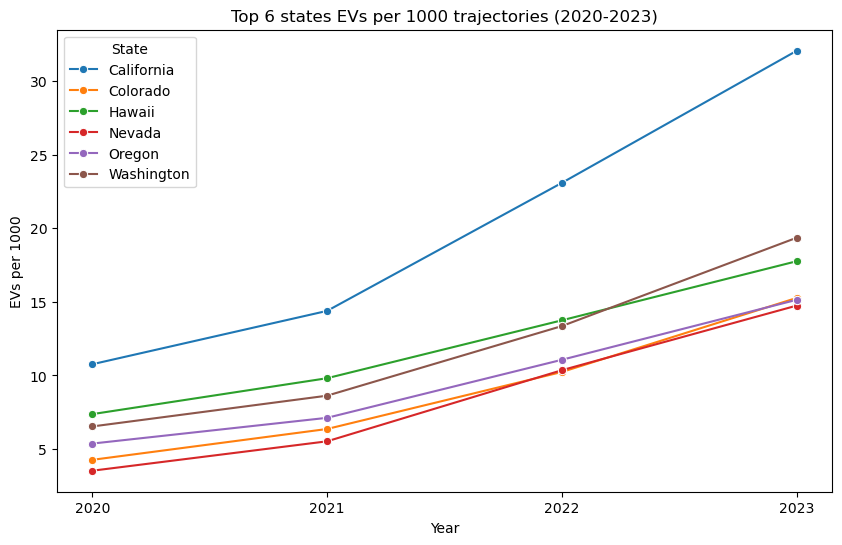

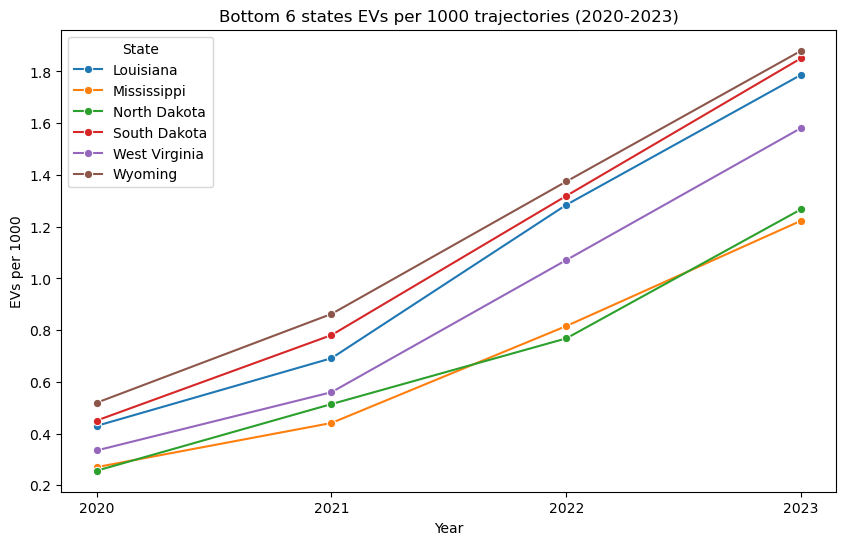

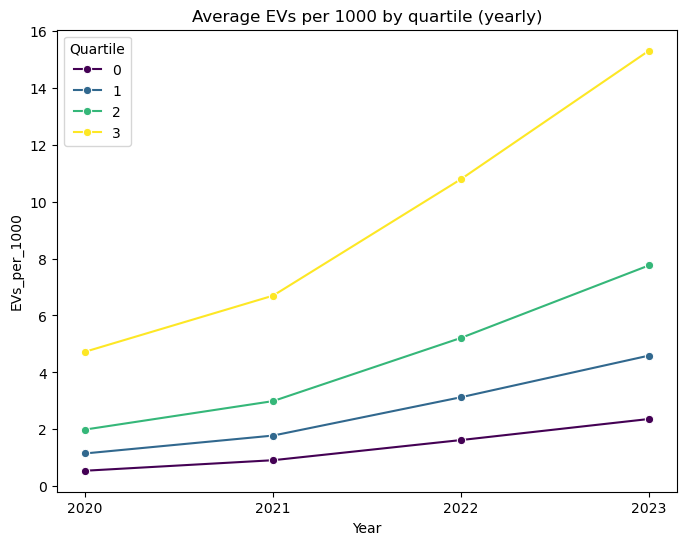


Yearly correlations:
       pearson  spearman
Year                    
2020  0.665256  0.809231
2021  0.696174  0.802534
2022  0.668609  0.798914
2023  0.671395  0.821448


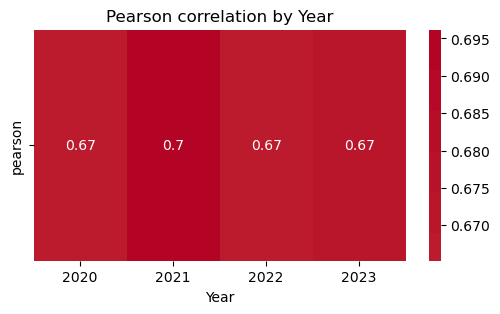

In [15]:
# 3) Small multiples: trajectories for top 6 and bottom 6 states by EVs per 1000
top_states = ranked['State'].head(6).tolist()
bottom_states = ranked['State'].tail(6).tolist()

def plot_trajectories(states, title):
    df = merged[merged['State'].isin(states)].copy()
    plt.figure(figsize=(10,6))
    sns.lineplot(data=df, x='Year', y='EVs_per_1000', hue='State', marker='o')
    ax = plt.gca()
    # force integer ticks for years
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    years = sorted(df['Year'].unique())
    ax.set_xticks(years)
    ax.set_xticklabels([int(y) for y in years])
    plt.title(title)
    plt.ylabel('EVs per 1000')
    plt.show()

plot_trajectories(top_states, f'Top 6 states EVs per 1000 trajectories (2020-{latest_year})')
plot_trajectories(bottom_states, f'Bottom 6 states EVs per 1000 trajectories (2020-{latest_year})')

# 4) Quartile-average trajectories
merged['EV_quartile'] = merged.groupby('Year')['EVs_per_1000'].transform(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop'))
quartile_avg = merged.groupby(['Year','EV_quartile'])['EVs_per_1000'].mean().reset_index()
plt.figure(figsize=(8,6))
sns.lineplot(data=quartile_avg, x='Year', y='EVs_per_1000', hue='EV_quartile', palette='viridis', marker='o')
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
years = sorted(quartile_avg['Year'].unique())
ax.set_xticks(years)
ax.set_xticklabels([int(y) for y in years])
plt.title('Average EVs per 1000 by quartile (yearly)')
plt.legend(title='Quartile')
plt.show()

# 5) Year-by-year correlation heatmap between Outlets_per_100k and EVs_per_1000
corrs = merged.groupby('Year').apply(lambda g: pd.Series({
    'pearson': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='pearson'),
    'spearman': g['Outlets_per_100k'].corr(g['EVs_per_1000'], method='spearman')
}))
print('\nYearly correlations:')
print(corrs)

plt.figure(figsize=(6,3))
sns.heatmap(corrs[['pearson']].T, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson correlation by Year')
plt.show()


In [16]:
# 6) States where outlets grew faster than EV adoption (potential overbuild) and vice versa
growth_filtered = growth.dropna()
growth_filtered['diff'] = growth_filtered['Outlets_growth_pct'] - growth_filtered['EV_growth_pct']
print('\nStates where Outlets grew faster than EVs (largest positive difference):')
print(growth_filtered.sort_values('diff', ascending=False).head(10).to_string(index=False))
print('\nStates where EVs grew faster than Outlets (largest negative difference):')
print(growth_filtered.sort_values('diff', ascending=True).head(10).to_string(index=False))


States where Outlets grew faster than EVs (largest positive difference):
        State  EV_growth_pct  Outlets_growth_pct        diff
      Arizona     199.876960           88.583481 -111.293479
       Alaska     198.577209           81.488107 -117.089101
       Hawaii     140.889804           14.082467 -126.807336
       Oregon     181.800475           50.051629 -131.748846
  Connecticut     245.029111          101.845200 -143.183911
Massachusetts     247.849420          103.817923 -144.031498
   Washington     196.200682           49.873594 -146.327088
         Ohio     246.847500           97.573792 -149.273708
   California     197.898652           42.711790 -155.186862
New Hampshire     260.536462          101.724712 -158.811750

States where EVs grew faster than Outlets (largest negative difference):
         State  EV_growth_pct  Outlets_growth_pct        diff
      Oklahoma     554.340024           91.915555 -462.424469
       Montana     391.199815           77.384022 -313.81

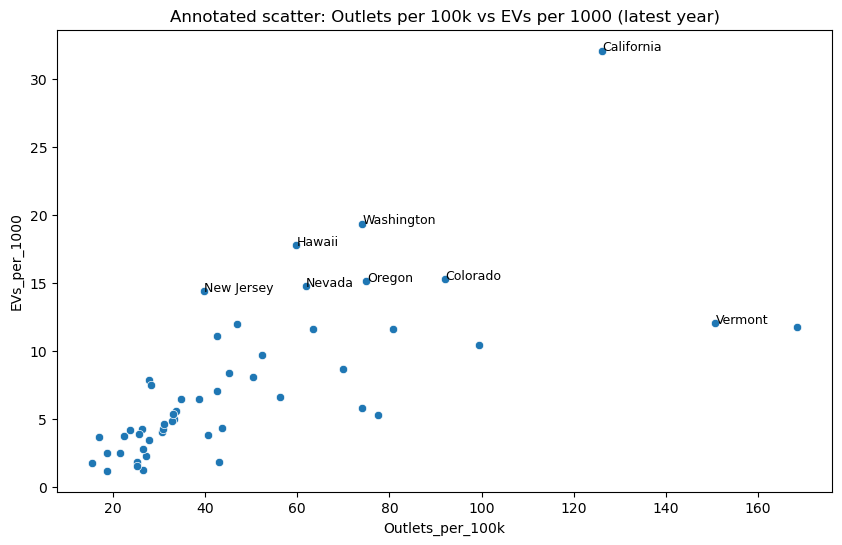

In [17]:
# 7) Scatter annotated for latest year: label a few interesting states
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_latest, x='Outlets_per_100k', y='EVs_per_1000')
for i, row in df_latest.sort_values('EVs_per_1000', ascending=False).head(8).iterrows():
    plt.text(row['Outlets_per_100k']+0.1, row['EVs_per_1000']+0.01, row['State'], fontsize=9)
plt.title('Annotated scatter: Outlets per 100k vs EVs per 1000 (latest year)')
plt.show()

### Prediction

In [18]:
# Forecasting EV adoption: panel regression + per-state ARIMA (where possible)
# Requires: merged DataFrame with State, Year, EVs_per_1000, Outlets_per_100k

# --- 1) Simple panel regression forecast (pooled) ---
# Fit EVs_per_1000 on Outlets_per_100k and a linear time trend, with state fixed effects
merged['Year_trend'] = merged['Year'] - merged['Year'].min()
panel_formula = 'EVs_per_1000 ~ Outlets_per_100k + Year_trend + C(State)'
panel_model = smf.ols(panel_formula, data=merged).fit(cov_type='cluster', cov_kwds={'groups': merged['State']})
print('Panel regression summary:')
print(panel_model.summary())

# Forecasting with panel model for 5 years ahead under two scenarios for outlets growth
last_year = merged['Year'].max()
forecast_years = list(range(last_year+1, last_year+6))

# Create baseline scenario: outlets grow at same average pct observed 2020->last_year per state
pct_outlet_growth = (merged[merged['Year']==last_year].set_index('State')['Outlets_per_100k'] - merged[merged['Year']==2020].set_index('State')['Outlets_per_100k']) / merged[merged['Year']==2020].set_index('State')['Outlets_per_100k']
avg_pct_growth = pct_outlet_growth.replace([np.inf, -np.inf], np.nan).dropna().mean()

# Scenario 1: baseline growth continues (compounded)
state_base = merged[merged['Year']==last_year].set_index('State')[['Outlets_per_100k','EVs_per_1000']]

forecast_rows = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    ev0 = row['EVs_per_1000']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth) ** i)
        year_trend = y - merged['Year'].min()
        # prepare data for prediction (need state dummies)
        pred_df = pd.DataFrame({
            'Outlets_per_100k': [outlets_proj],
            'Year_trend': [year_trend],
            'State': [state]
        })
        pred = panel_model.predict(pred_df)[0]
        forecast_rows.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_baseline': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel = pd.DataFrame(forecast_rows)
print('\nPanel-model forecasts (baseline scenario) - sample:')
print(forecast_panel.groupby('Year')['EVs_per_1000_forecast_panel_baseline'].mean())

# Scenario 2: accelerated outlets rollout (+10% relative growth)
acc = 0.10
forecast_rows_acc = []
for state, row in state_base.iterrows():
    outlets0 = row['Outlets_per_100k']
    for i, y in enumerate(forecast_years, start=1):
        outlets_proj = outlets0 * ((1 + avg_pct_growth + acc) ** i)
        year_trend = y - merged['Year'].min()
        pred_df = pd.DataFrame({'Outlets_per_100k': [outlets_proj], 'Year_trend': [year_trend], 'State': [state]})
        pred = panel_model.predict(pred_df)[0]
        forecast_rows_acc.append({'State': state, 'Year': y, 'EVs_per_1000_forecast_panel_acc': pred, 'Outlets_per_100k_proj': outlets_proj})

forecast_panel_acc = pd.DataFrame(forecast_rows_acc)
print('\nPanel-model forecasts (accelerated outlets) - sample:')
print(forecast_panel_acc.groupby('Year')['EVs_per_1000_forecast_panel_acc'].mean())

# --- 2) Per-state ARIMA time-series forecasts (only for states with >=3 data points) ---
arima_forecasts = []
for state, g in merged.groupby('State'):
    g_sorted = g.sort_values('Year')
    if len(g_sorted) >= 3:
        ts = g_sorted.set_index('Year')['EVs_per_1000']
        try:
            model = ARIMA(ts, order=(1,1,0)).fit()
            fc = model.get_forecast(steps=5)
            mean_fc = fc.predicted_mean
            for i, y in enumerate(forecast_years):
                arima_forecasts.append({'State': state, 'Year': y, 'EVs_per_1000_arima': float(mean_fc.iloc[i])})
        except Exception:
            continue

arima_df = pd.DataFrame(arima_forecasts)
print('\nARIMA forecast sample (mean across states):')
if not arima_df.empty:
    print(arima_df.groupby('Year')['EVs_per_1000_arima'].mean())
else:
    print('Not enough data for ARIMA forecasts.')

# --- Save forecasts to CSVs for inspection ---
forecast_panel.to_csv('forecast_panel_baseline.csv', index=False)
forecast_panel_acc.to_csv('forecast_panel_accelerated.csv', index=False)
arima_df.to_csv('forecast_arima.csv', index=False)

print('\nForecast CSVs saved: forecast_panel_baseline.csv, forecast_panel_accelerated.csv, forecast_arima.csv')

# Notes for interpretation: use panel_model params for elasticity estimate; compare panel vs ARIMA to see structural differences.



Panel regression summary:
                            OLS Regression Results                            
Dep. Variable:           EVs_per_1000   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     23.70
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           5.76e-08
Time:                        16:25:38   Log-Likelihood:                -346.15
No. Observations:                 204   AIC:                             798.3
Df Residuals:                     151   BIC:                             974.2
Df Model:                          52                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

Gas Price Data Set

Data Cleaning

In [35]:
gas_prices_path = 'DSC190/Datasets/10641_gasoline_prices_by_year_1-26-24.xlsx'

In [36]:
gas_prices = pd.read_excel(gas_prices_path, skiprows=1)

In [37]:
gas_prices.columns = gas_prices.iloc[0]
gas_prices = gas_prices.drop(index=0).reset_index(drop=True)

In [ ]:
gas_prices = gas_prices.dropna(axis=1, how='all')
gas_prices["year"] = pd.to_numeric(gas_prices["Year"], errors="coerce")
gas_prices["Gasoline Price ($/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price ($/gallon)"], errors="coerce")
gas_prices["Gasoline Price (2023 $/gallon)"] = pd.to_numeric(gas_prices["Gasoline Price (2023 $/gallon)"], errors="coerce")
# Drop the duplicate 'year' column (keep 'Year')
gas_prices = gas_prices.drop('year', axis=1)

# Remove rows where Year is not numeric (the footer text)
gas_prices = gas_prices[gas_prices['Year'].apply(lambda x: str(x).replace('.','').isdigit())]

# Convert Year to integer
gas_prices['Year'] = gas_prices['Year'].astype(int)


# Reset the index
gas_prices = gas_prices.reset_index(drop=True)

gas_prices.head()



,Year,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,1950,0.268,12.28,3.29104
1,1951,0.272,11.59,3.15248
2,1952,0.274,11.5,3.15100
3,1953,0.287,11.41,3.27467
4,1954,0.290,11.5,3.33500


In [64]:
gas_prices.columns

Index(['Year', 'Gasoline Price ($/gallon)', 'Inflation Adjuster',
       'Gasoline Price (2023 $/gallon)'],
      dtype='object', name=0)

In [66]:
# Change object type to float
gas_prices['Inflation Adjuster'] = gas_prices['Inflation Adjuster'].astype(float)

In [67]:
merged

,State,Charging_Outlets,Year,Registrations,Population,Outlets_per_100k,EVs_per_1000,log_Outlets_pc,log_EVs_pc,EV_quartile,Year_trend
0,Alabama,598,2020,2900,5033094,11.881360,0.576186,0.000119,0.000576,0,0
1,Alaska,68,2020,900,733017,9.276729,1.227802,0.000093,0.001227,1,0
2,Arizona,1788,2020,28800,7187135,24.877785,4.007160,0.000249,0.003999,3,0
3,Arkansas,350,2020,1300,3014546,11.610372,0.431242,0.000116,0.000431,0,0
4,California,34924,2020,425300,39521958,88.366067,10.761107,0.000883,0.010704,3,0
...,...,...,...,...,...,...,...,...,...,...,...
199,Virginia,4565,2023,84900,8734685,52.262904,9.719870,0.000522,0.009673,2,3
200,Washington,5817,2023,152100,7857320,74.032876,19.357745,0.000740,0.019173,3,3
201,West Virginia,446,2023,2800,1770495,25.190695,1.581479,0.000252,0.001580,0,3
202,Wisconsin,1398,2023,24900,5930405,23.573432,4.198701,0.000236,0.004190,1,3


In [68]:
# Create a simplified DataFrame with just Year and Registrations (summed across all states)
registrations_by_year = merged.groupby('Year')['Registrations'].sum().reset_index()

# Merge with gas prices
registrations_gas = registrations_by_year.merge(gas_prices, on='Year', how='left')


In [69]:
registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon)
0,2020,1018900,2.170,1.18,2.56060
1,2021,1454400,3.050,1.10,3.35500
2,2022,2442300,4.094,1.03,4.21682
3,2023,3555900,3.500,1.00,3.50000


In [70]:
print("\n" + "="*80)
print("1. DATASET OVERVIEW")
print("="*80)

print("\nDataset Shape:", registrations_gas.shape)
print("\nColumn Names and Types:")
print(registrations_gas.dtypes)
print("\nFirst Few Rows:")
print(registrations_gas.head())
print("\nDataset Info:")
print(registrations_gas.info())

# Check for missing values
print("\nMissing Values:")
print(registrations_gas.isnull().sum())

# Check for duplicates
print(f"\nDuplicate Rows: {registrations_gas.duplicated().sum()}")


1. DATASET OVERVIEW

Dataset Shape: (4, 5)

Column Names and Types:
Year                                int64
Registrations                       int64
Gasoline Price ($/gallon)         float64
Inflation Adjuster                float64
Gasoline Price (2023 $/gallon)    float64
dtype: object

First Few Rows:
   Year  Registrations  Gasoline Price ($/gallon)  Inflation Adjuster  \
0  2020        1018900                      2.170                1.18   
1  2021        1454400                      3.050                1.10   
2  2022        2442300                      4.094                1.03   
3  2023        3555900                      3.500                1.00   

   Gasoline Price (2023 $/gallon)  
0                         2.56060  
1                         3.35500  
2                         4.21682  
3                         3.50000  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
 #   Column                  

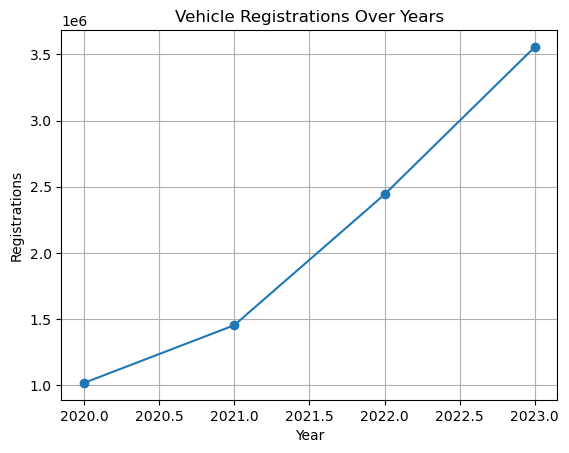

In [74]:
# Plot vechicle registrations over the years
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o')
plt.title('Vehicle Registrations Over Years')
plt.xlabel('Year')
plt.ylabel('Registrations')
plt.grid(True)
plt.show()


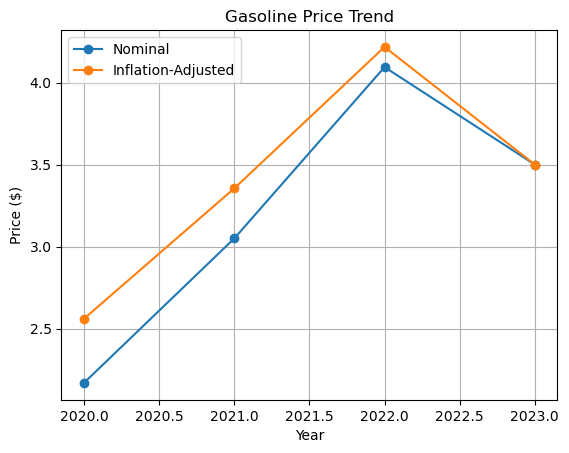

In [76]:
#Gasoline Price trend

plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)'], marker='o', label='Nominal')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price (2023 $/gallon)'], marker='o', label='Inflation-Adjusted')
plt.title('Gasoline Price Trend')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


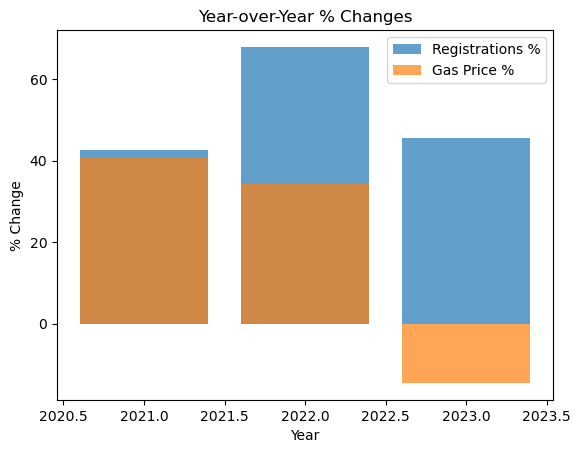

In [ ]:
# Year over Year changes 

registrations_gas['Reg_YoY_Change'] = registrations_gas['Registrations'].diff()
registrations_gas['Reg_YoY_Pct'] = registrations_gas['Registrations'].pct_change() * 100
registrations_gas['GasPrice_YoY_Change'] = registrations_gas['Gasoline Price ($/gallon)'].diff()
registrations_gas['GasPrice_YoY_Pct'] = registrations_gas['Gasoline Price ($/gallon)'].pct_change() * 100

plt.bar(registrations_gas['Year'][1:], registrations_gas['Reg_YoY_Pct'][1:], alpha=0.7, label='Registrations %')
plt.bar(registrations_gas['Year'][1:], registrations_gas['GasPrice_YoY_Pct'][1:], alpha=0.7, label='Gas Price %')
plt.title('Year-over-Year % Changes')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

#Easier Column names
registrations_gas.rename(columns={
    'Reg_YoY_Pct': 'RegPct',
    'GasPrice_YoY_Pct': 'GasPct'
}, inplace=True)



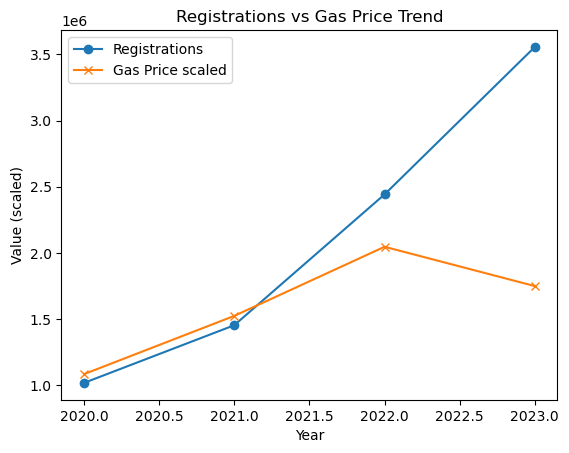

In [ ]:
# Both trends
plt.plot(registrations_gas['Year'], registrations_gas['Registrations'], marker='o', label='Registrations')
plt.plot(registrations_gas['Year'], registrations_gas['Gasoline Price ($/gallon)']*500000, marker='x', label='Gas Price scaled')
plt.title('Registrations vs Gas Price Trend')
plt.xlabel('Year')
plt.ylabel('Value (scaled)')
plt.legend()
plt.show()


In [87]:
registrations_gas['Price_Difference'] = registrations_gas['Gasoline Price (2023 $/gallon)'] - registrations_gas['Gasoline Price ($/gallon)']

registrations_gas

,Year,Registrations,Gasoline Price ($/gallon),Inflation Adjuster,Gasoline Price (2023 $/gallon),Reg_YoY_Change,RegPct,GasPrice_YoY_Change,GasPct,Reg_YoY_Pct,GasPrice_YoY_Pct,Price_Difference
0,2020,1018900,2.170,1.18,2.56060,NaN,NaN,NaN,NaN,NaN,NaN,0.39060
1,2021,1454400,3.050,1.10,3.35500,435500.0,42.742173,0.880,40.552995,42.742173,40.552995,0.30500
2,2022,2442300,4.094,1.03,4.21682,987900.0,67.924917,1.044,34.229508,67.924917,34.229508,0.12282
3,2023,3555900,3.500,1.00,3.50000,1113600.0,45.596364,-0.594,-14.509038,45.596364,-14.509038,0.00000


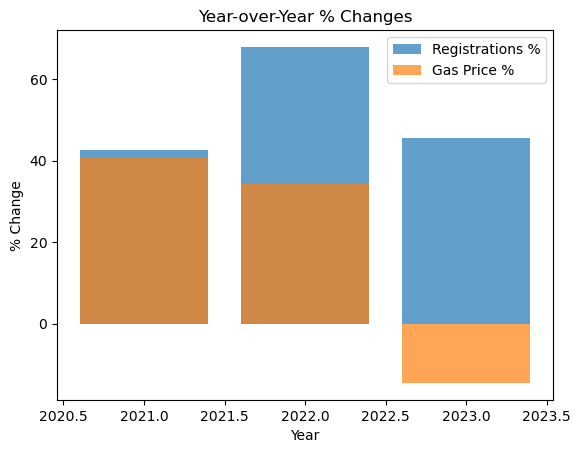

In [102]:
# Year over Year changes 

registrations_gas['Reg_YoY_Change'] = registrations_gas['Registrations'].diff()
registrations_gas['Reg_YoY_Pct'] = registrations_gas['Registrations'].pct_change() * 100
registrations_gas['GasPrice_YoY_Change'] = registrations_gas['Gasoline Price ($/gallon)'].diff()
registrations_gas['GasPrice_YoY_Pct'] = registrations_gas['Gasoline Price ($/gallon)'].pct_change() * 100

plt.bar(registrations_gas['Year'][1:], registrations_gas['Reg_YoY_Pct'][1:], alpha=0.7, label='Registrations %')
plt.bar(registrations_gas['Year'][1:], registrations_gas['GasPrice_YoY_Pct'][1:], alpha=0.7, label='Gas Price %')
plt.title('Year-over-Year % Changes')
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

#Easier Column names
registrations_gas.rename(columns={
    'Reg_YoY_Pct': 'RegPct',
    'GasPrice_YoY_Pct': 'GasPct'
}, inplace=True)



CORRELATION MATRIX
                                Registrations  Gasoline Price ($/gallon)  \
Registrations                        1.000000                   0.711327   
Gasoline Price ($/gallon)            0.711327                   1.000000   
Gasoline Price (2023 $/gallon)       0.591983                   0.987552   
Reg_YoY_Change                       0.927549                   0.712186   
Reg_YoY_Pct                          0.069103                   0.942603   
GasPrice_YoY_Change                 -0.836406                   0.169668   
GasPrice_YoY_Pct                    -0.927192                  -0.025657   

                                Gasoline Price (2023 $/gallon)  \
Registrations                                         0.591983   
Gasoline Price ($/gallon)                             0.987552   
Gasoline Price (2023 $/gallon)                        1.000000   
Reg_YoY_Change                                        0.484896   
Reg_YoY_Pct                              

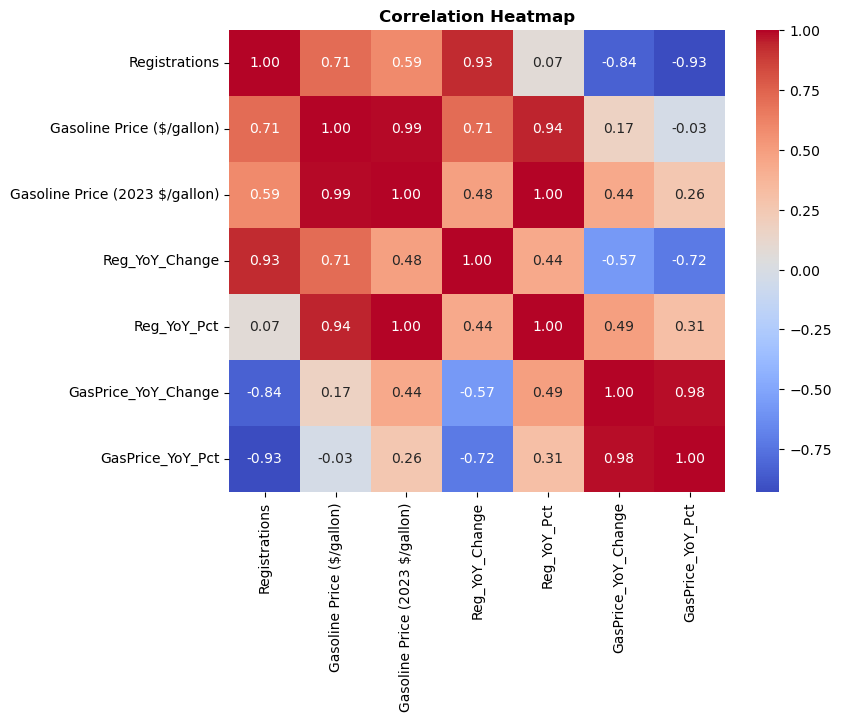

In [93]:
#Correlation analysis
numeric_cols = ['Registrations', 'Gasoline Price ($/gallon)', 'Gasoline Price (2023 $/gallon)',
                'Reg_YoY_Change', 'Reg_YoY_Pct', 'GasPrice_YoY_Change', 'GasPrice_YoY_Pct']
corr = registrations_gas[numeric_cols].corr()

print("\n" + "="*80)
print("CORRELATION MATRIX")
print("="*80)
print(corr)

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap", fontweight='bold')
plt.show()

a) Registrations vs Gas Prices
- Registrations & Gasoline Price ($/gallon) : 0.71
  Interpretation: Moderate positive relationship. Higher gas prices → more EV registrations.
- Registrations & Gasoline Price (2023 $/gallon) : 0.59
  Interpretation: Slightly weaker positive correlation with inflation-adjusted prices.

b) Year-over-Year Registration Changes
- Reg_YoY_Change & Registrations : 0.93
  Interpretation: Very strong. Absolute registration changes track total registrations closely.
- Reg_YoY_Pct & Registrations : 0.069
  Interpretation: Very weak. Percent change behaves differently from totals.

c) Gas Price YoY Changes
- GasPrice_YoY_Change & Registrations : -0.84
  Interpretation: Negative correlation. Year-over-year gas price increases may not immediately drive registrations.
- GasPrice_YoY_Pct & Registrations : -0.93
  Interpretation: Strong negative correlation. Percent changes show similar pattern.

d) Inflation-Adjusted Gas Price
- Gasoline Price (2023 $/gallon) & Reg_YoY_Pct : 0.9985
  Interpretation: Almost perfect correlation. Inflation-adjusted price dominates percent growth metrics.

e) YoY Gas Price Changes
- GasPrice_YoY_Change & GasPrice_YoY_Pct : 0.98
  Interpretation: Absolute and percent changes are almost perfectly linearly related.


STATE-LEVEL EV ADOPTION REGRESSION RESULTS
                            OLS Regression Results                            
Dep. Variable:        log_EV_per_1000   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     197.2
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           4.07e-48
Time:                        17:07:28   Log-Likelihood:                -97.164
No. Observations:                 204   AIC:                             200.3
Df Residuals:                     201   BIC:                             210.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

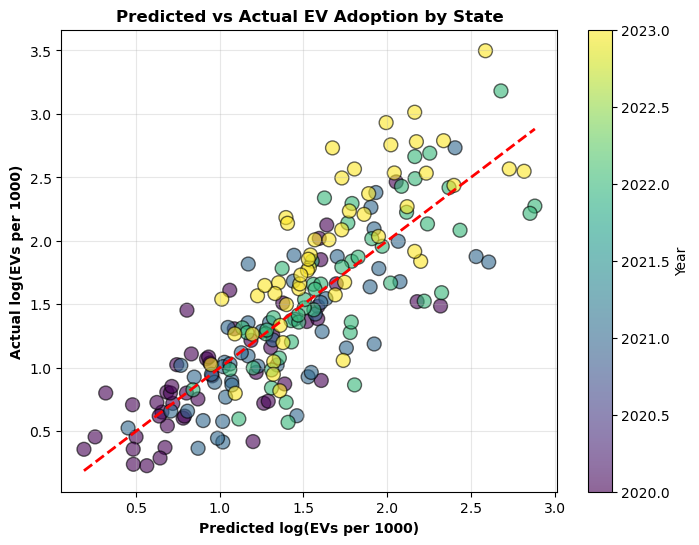

In [ ]:


#Merge datasets
# ---------------------------
# registration_gas (national-level)
# merged (state-level)

merged_reg = merged.merge(
    registrations_gas[['Year', 'Gasoline Price (2023 $/gallon)', 'Reg_YoY_Pct']],
    on='Year',
    how='left'
)

# Log-transform skewed variables

# This helps stabilize variance and interpret coefficients as elasticities
merged_reg['log_EV_per_1000'] = np.log1p(merged_reg['EVs_per_1000'])
merged_reg['log_Outlets_pc'] = np.log1p(merged_reg['Outlets_per_100k'])

# Define predictors and target

# You can use both state-level and national-level variables
X = merged_reg[['log_Outlets_pc', 'Gasoline Price (2023 $/gallon)']]
y = merged_reg['log_EV_per_1000']  # log-transformed EV adoption per 1000 people

# Add constant term for intercept
X_const = sm.add_constant(X)


# Fit OLS regression
model = sm.OLS(y, X_const).fit()
print("\n" + "="*80)
print("STATE-LEVEL EV ADOPTION REGRESSION RESULTS")
print("="*80)
print(model.summary())


# Predicted vs Actual Plot

merged_reg['predicted_EV'] = model.predict(X_const)
plt.figure(figsize=(8,6))
plt.scatter(merged_reg['predicted_EV'], merged_reg['log_EV_per_1000'], alpha=0.6, edgecolors='black', c=merged_reg['Year'], cmap='viridis', s=100)
plt.plot([merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         [merged_reg['predicted_EV'].min(), merged_reg['predicted_EV'].max()],
         'r--', linewidth=2)
plt.xlabel('Predicted log(EVs per 1000)', fontweight='bold')
plt.ylabel('Actual log(EVs per 1000)', fontweight='bold')
plt.title('Predicted vs Actual EV Adoption by State', fontweight='bold')
plt.colorbar(label='Year')
plt.grid(alpha=0.3)
plt.show()


State-level charging infrastructure (log_Outlets_pc)
Positive and strong effect (coef ≈ 0.8)
Interpretation: More charging outlets per 100k people → more EVs per 1000 people
Roughly, a 1% increase in outlets → 0.8% increase in EV adoption

National gas prices (Gasoline Price (2023 $/gallon))
Positive and significant effect (coef ≈ 0.27)
Interpretation: Higher gas prices → higher EV adoption
Suggests that rising fuel costs encourage EV purchases

R² ≈ 0.66: 66% of the variation in EV adoption across states and years is explained by charging outlets and gas prices

Both predictors have p < 0.001, so we are confident these relationships are not due to random chance
Residuals appear roughly normal (Omnibus/JB tests)